In [ ]:
! pip install gpytorch
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import tqdm
from torch.optim.lr_scheduler import MultiStepLR
import gpytorch
import math
import numpy as np
import os
from PIL import Image

     |████████████████████████████████| 245kB 6.0MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.1.1-py2.py3-none-any.whl size=400467 sha256=2df8d6887b132531165ed941a26505682095dc0b4413b9c0494d7095aaab4b7f
  Stored in directory: /root/.cache/pip/wheels/e5/a5/29/4dafc0624adf678108e0067836556f0c72588e85d851d78ae0
Successfully built gpytorch


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
% cd /content/drive/My Drive/Colab Notebooks/UCMerced_LandUse
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
args = {'log_interval': 1, 'learning_rate': 1e-3, 'step_size': 50, 'gamma': 0.1, 'n_epochs': 200, 'batch_size_train': 128, 'batch_size_test': 64}
torch.manual_seed(1)
print(use_cuda)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/UCMerced_LandUse
True


In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, mode, split):
    path = './Images/'
    categories = os.listdir(path)
    imgs = []
    target = []
    for category_idx in (range(len(categories))):
      img_categories = os.listdir(path + categories[category_idx])
      for img_idx in (range(len(img_categories))):
        im_path = path + categories[category_idx] + '/' + img_categories[img_idx]
        imgs.append(im_path)
        target.append(category_idx)
    self.imgs = np.array(imgs)
    self.target = np.array(target)
    self.img_exceptions = [130, 183, 209, 243, 396, 504, 505, 506, 507, 622, 623, 624, 633, 
                           770, 788, 858, 861, 863, 864, 865, 866, 867, 868, 869, 870, 915, 
                           935, 945, 993, 1055, 1060, 1077, 1122, 1145, 1146, 1308, 1320, 
                           1699, 1714, 1736, 1857, 2060, 2062, 2063]
    self.img_idxs = []
    for idx in range(len(imgs)):
      if idx not in self.img_exceptions:
        self.img_idxs.append(idx)

    self.img_idxs = np.array(self.img_idxs)
    np.random.shuffle(self.img_idxs)

    self.imgs = self.imgs[self.img_idxs]
    self.target = self.target[self.img_idxs]
    self.num_classes = max(self.target)
    self.categories = categories

    split_idx = int(len(self.imgs) * split)
    if mode == 'train':
        self.imgs = self.imgs[:split_idx]
        self.target = self.target[:split_idx]
    elif mode == 'test':
        self.imgs = self.imgs[split_idx:]
        self.target = self.target[split_idx:]

  def __len__(self):
    return len(self.imgs)
  
  def __getitem__(self, index):
    idx = index
    
    im_path = self.imgs[idx]
    im = Image.open(im_path)
    im = np.array(im) / 255.

    means = [0.5, 0.5, 0.5]
    stds = [0.5, 0.5, 0.5]

    for ch in range(3):
        im[:,:,ch] = (im[:,:,ch] - means[ch]) / stds[ch]

    return im.reshape((3,256,256)), self.target[idx]

In [ ]:
train_dataset = Dataset('train', 0.7)
test_dataset = Dataset('test', 0.7)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle = True)

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_features):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(59536, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_features)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 59536)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x
    
class GaussianProcessLayer(gpytorch.models.ApproximateGP):
    def __init__(self, num_dim, grid_bounds=(-10., 10.), grid_size=64):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=grid_size, batch_shape=torch.Size([num_dim])
        )
        variational_strategy = gpytorch.variational.MultitaskVariationalStrategy(
            gpytorch.variational.GridInterpolationVariationalStrategy(
                self, grid_size=grid_size, grid_bounds=[grid_bounds],
                variational_distribution=variational_distribution,
            ), num_tasks=num_dim,
        )
        super().__init__(variational_strategy)
        
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                )
            )
        )
        self.mean_module = gpytorch.means.ConstantMean()
        self.grid_bounds = grid_bounds

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

class DKLModel(gpytorch.Module):
    def __init__(self, feature_extractor, num_dim, likelihood, grid_bounds=(-10., 10.)):
        super(DKLModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.gp_layer = GaussianProcessLayer(num_dim=num_dim, grid_bounds=grid_bounds)
        self.grid_bounds = grid_bounds
        self.num_dim = num_dim
        self.likelihood = likelihood
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        features = self.feature_extractor(x)
        features = gpytorch.utils.grid.scale_to_bounds(features, self.grid_bounds[0], self.grid_bounds[1])
        features = features.transpose(-1, -2).unsqueeze(-1)
        res_gp = self.gp_layer(features)
        return res_gp

def train(args, model, likelihood, mll, device, train_loader, optimizer, epoch):
    model.train()

    total_loss = 0
    loss_fn = nn.NLLLoss()

    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc=f"(Epoch {epoch}) Minibatch")
    with gpytorch.settings.num_likelihood_samples(8):
      for data, target in minibatch_iter:
          data = data.to(device).float()
          target = target.to(device)
          optimizer.zero_grad()
          output = model(data)
          loss = F.nll_loss(output, target)
          total_loss += loss.item()
          loss.backward()
          optimizer.step()
          minibatch_iter.set_postfix(loss=loss.item())
    total_loss /= len(train_loader.dataset)
    return total_loss

def test(model, likelihood, mll, device, test_loader, epoch):
    model.eval()
    #likelihood.eval()
    test_loss = 0
    correct = 0
    minibatch_iter = tqdm.notebook.tqdm(test_loader, desc=f"(Epoch {epoch}) Minibatch")
    with torch.no_grad(), gpytorch.settings.num_likelihood_samples(16):
        for data, target in minibatch_iter:
            data = data.to(device).float()
            target = target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            test_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    return test_loss, correct / len(test_loader.dataset)

In [ ]:
num_dim = 10
num_classes = train_loader.dataset.num_classes
model = CNN(num_classes)

model = model.to(device)
optimizer = SGD(model.parameters(), lr=args['learning_rate'], momentum=0.9, nesterov=True, weight_decay=0)
scheduler = StepLR(optimizer, step_size=args['step_size'], gamma=args['gamma'])
print(num_classes)

20


In [ ]:
for epoch in range(1, args['n_epochs'] + 1):
  train_loss = train(args, model, None, None, device, train_loader, optimizer, epoch)
  test_loss, acc = test(model, None, None, device, test_loader, epoch)
  print('\n==> Epoch: {}, Train Loss: {:.4e}, Test Loss: {:.4e}, Test Acc: {:.4e}'.format(epoch, train_loss, test_loss, acc))
  scheduler.step()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.




==> Epoch: 1, Train Loss: 2.7894e+00, Test Loss: 2.7030e+00, Test Acc: 1.1994e-01




==> Epoch: 2, Train Loss: 2.7331e+00, Test Loss: 2.7196e+00, Test Acc: 8.7520e-02




==> Epoch: 3, Train Loss: 2.6165e+00, Test Loss: 2.5327e+00, Test Acc: 1.6045e-01




==> Epoch: 4, Train Loss: 2.5668e+00, Test Loss: 2.4039e+00, Test Acc: 1.5721e-01




==> Epoch: 5, Train Loss: 2.4527e+00, Test Loss: 2.5192e+00, Test Acc: 1.2804e-01




==> Epoch: 6, Train Loss: 2.2908e+00, Test Loss: 2.2856e+00, Test Acc: 2.0908e-01




==> Epoch: 7, Train Loss: 2.1716e+00, Test Loss: 2.2684e+00, Test Acc: 2.3663e-01




==> Epoch: 8, Train Loss: 1.9984e+00, Test Loss: 1.7145e+00, Test Acc: 4.2301e-01




==> Epoch: 9, Train Loss: 1.6192e+00, Test Loss: 1.9210e+00, Test Acc: 4.5867e-01




==> Epoch: 10, Train Loss: 1.1994e+00, Test Loss: 1.6843e+00, Test Acc: 5.0405e-01




==> Epoch: 11, Train Loss: 1.2370e+00, Test Loss: 1.7365e+00, Test Acc: 5.3160e-01


Individual Testing

1.0


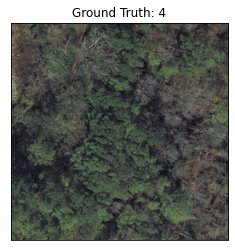

In [ ]:
model.eval()
examples = iter(test_loader)
example_data, example_targets = next(examples)
data, target = example_data.to(device).float().view(-1,3,256,256), example_targets.to(device)
output = model(data)
observed_pred = likelihood(output)
preds = observed_pred.probs.mean(0).cpu()
pred = preds.argmax(-1)
pred_distribution = preds.cpu().detach().numpy()
var = observed_pred.probs.view((-1,train_dataset.num_classes)).var(1).cpu().detach().numpy()
print(pred.eq(example_targets.view_as(pred)).cpu().sum().item() / float(len(pred)))

idx = 0
fig = plt.figure()
plt.tight_layout()
im = example_data[idx].view((256,256,-1)) * 0.5 + 0.5
plt.imshow(im)
plt.title("Ground Truth: {}".format(example_targets[idx]))
plt.xticks([])  
plt.yticks([])
plt.show()

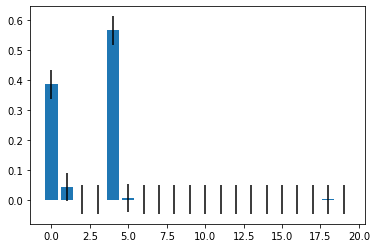

In [ ]:
plt.figure()
plt.bar(np.arange(train_dataset.num_classes), pred_distribution[idx].squeeze(), yerr=var[idx].squeeze())
plt.show()

In [ ]:
pred[idx].item(), example_targets[idx].item()

(4, 4)

In [ ]:
train_dataset.categories[pred[idx].item()], train_dataset.categories[example_targets[idx].item()]

('forest', 'forest')

In [ ]:
pred_distribution[idx]

array([3.84902090e-01, 4.22527641e-02, 1.21948351e-05, 1.30574870e-06,
       5.65320134e-01, 6.22384017e-03, 1.77999500e-08, 3.14467965e-04,
       2.80171989e-05, 2.03644260e-04, 1.29229811e-05, 1.67012422e-05,
       7.25710288e-06, 3.94964536e-06, 1.16276322e-04, 2.84280958e-07,
       1.32170753e-05, 1.35126365e-05, 5.50360652e-04, 7.04955664e-06],
      dtype=float32)

In [ ]:
var

array([0.04763656, 0.02717953, 0.04235103, 0.0226156 , 0.03330511,
       0.03051318, 0.0167819 , 0.02344266, 0.02349811, 0.04508165],
      dtype=float32)